In [26]:
from PIL import Image
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import random

dataImages = []
solutionImages = []

IMAGE_SIZE = 128
OUTPUT_CHANNELS = 2

In [2]:
def loadImagesInArray(path):
    ret = []
    for image in os.listdir(path): 
        img_array = cv2.imread(os.path.join(path, image)) #, cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, (IMAGE_SIZE, IMAGE_SIZE))     
        ret.append(img_array)
    return ret

In [3]:
image_Array = loadImagesInArray("E:\\OneDrive\\Programming\\TU-Freiberg-Kamera\\SampleImages\\dataset\\image\\")
print("I have found " + str(len(image_Array)) + " images.")
mask_Array = loadImagesInArray("E:\\OneDrive\\Programming\\TU-Freiberg-Kamera\\SampleImages\\dataset\\result\\")
print("I have found " + str(len(mask_Array))+ " masks.")

print(np.shape(mask_Array))
print(np.shape(image_Array))

I have found 53 images.
I have found 53 masks.
(53, 128, 128, 3)
(53, 128, 128, 3)


In [4]:
def scramble(origin):
    dest = origin[:]
    random.shuffle(dest)
    return dest 

In [5]:
def mask_correction(masks):     
    for img in masks: 
        for x in img:
            for i,y in enumerate(x): 
                y = tuple(y)
                if y != (255, 0, 0) and y != (0, 0, 255):
                    if y[0] > y[2]: 
                        x[i] = (255, 0, 0)
                    else: 
                        x[i] = (0, 0, 255)
    return masks

In [6]:
mask_Array = mask_correction(mask_Array)

In [7]:
#test fif there are pixels other than class 1 or class 3 
counter = 0
array = []
for x in mask_Array[0]: 
    for y in x: 
        y = tuple(y)
        #print(y)
        if y != (255, 0, 0) and y != (0, 0, 255):
            counter = counter + 1
            array.append(y)
print(counter)
print(array)

0
[]


In [8]:
def normalize(input_image, input_mask): 
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = input_mask # evtl noch umbasteln, dass jede position entweder 0 oder 1 (evtl 2) ist >> 0 - nüx, 1 - street, (2? rand?)
    return input_image, input_mask

In [9]:
def load_image_test(input_image, input_mask): #rezizes the images to 128x128
  output_image = tf.image.resize(input_image, (IMAGE_SIZE, IMAGE_SIZE))
  output_mask = tf.image.resize(input_mask, (IMAGE_SIZE, IMAGE_SIZE))

  output_image, output_mask = normalize(output_image, output_mask)

  return input_image, input_mask

In [10]:
#print(np.shape(image_Array))
image, mask = load_image_test(image_Array, mask_Array)
#print(np.shape(image))


In [11]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('on')
  plt.show()

In [12]:
def getTestData(input_image, input_mask): 
    data = []
    #print(np.shape(input_image))
    for index in range(len(input_image)): 
        data.append( (input_image[index], input_mask[index]) )

    #print(np.shape(data))
    temp = data.copy()
    for img, mask in temp: 
        t1 = tf.image.flip_left_right(img)
        t2 = tf.image.flip_left_right(mask)
        data.append( (t1, t2) )
    
    data = scramble(data)

    index = int(len(data)*0.1)

    data, train = data[:index], data[index:]
    
    #print(np.shape(data))
    #print(np.shape(train))


    return train, data

In [13]:
def manualDisplay(inputImage, inputMask):
    title = ['Input Image', 'True Mask']
    for i in range(len(inputImage)): 
        print("Index: " + str(i))
        display([inputImage[i], inputMask[i]])


In [14]:
#manualDisplay(image, mask)

In [15]:
training_data, test_data = getTestData(image, mask)

# function welche aufgerufen wird... um einen gewissen % satz aus den daten zu greifen, zum trainiern und testen...
# https://youtu.be/j-3vuBynnOE?t=530
# https://www.tensorflow.org/tutorials/images/segmentation#next_steps

96
10


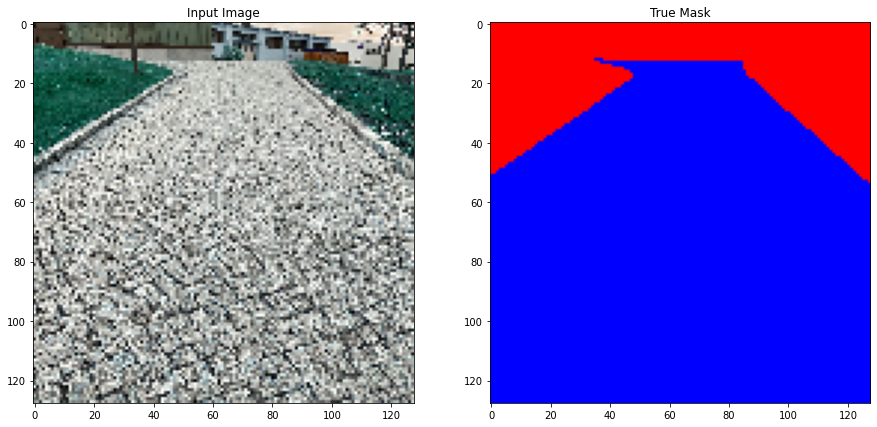

In [16]:
print(len(training_data))
print(len(test_data))


sample_image = training_data[0][0]
sample_mask = training_data[0][1]

display([sample_image, sample_mask])

Index: 0


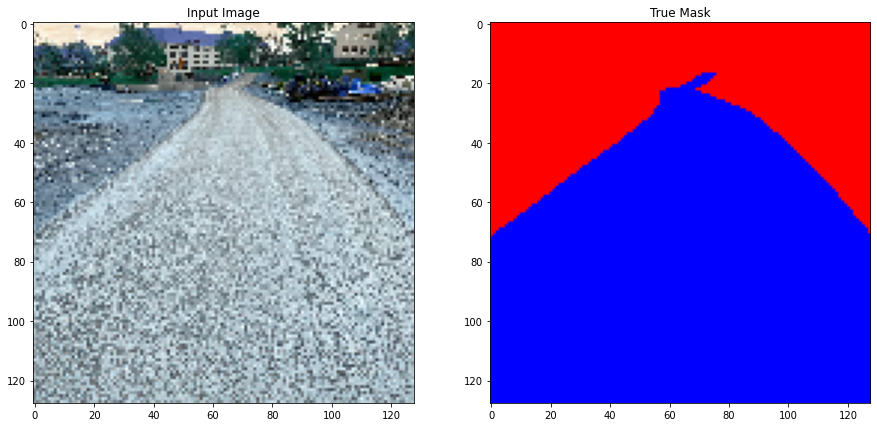

Index: 1


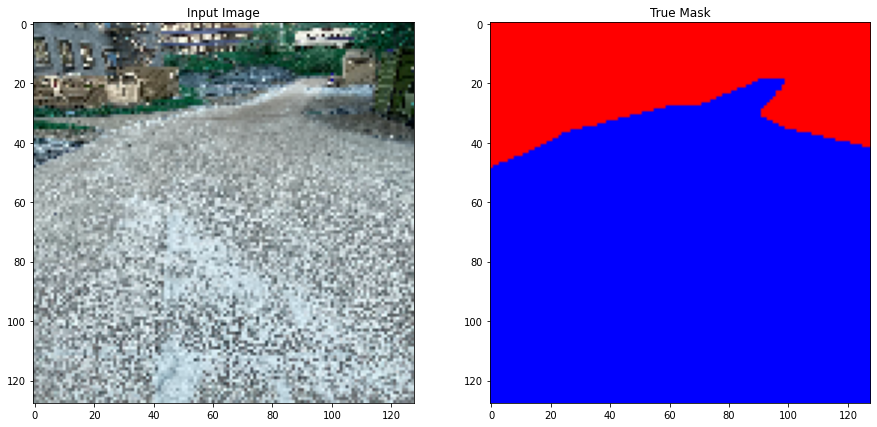

Index: 2


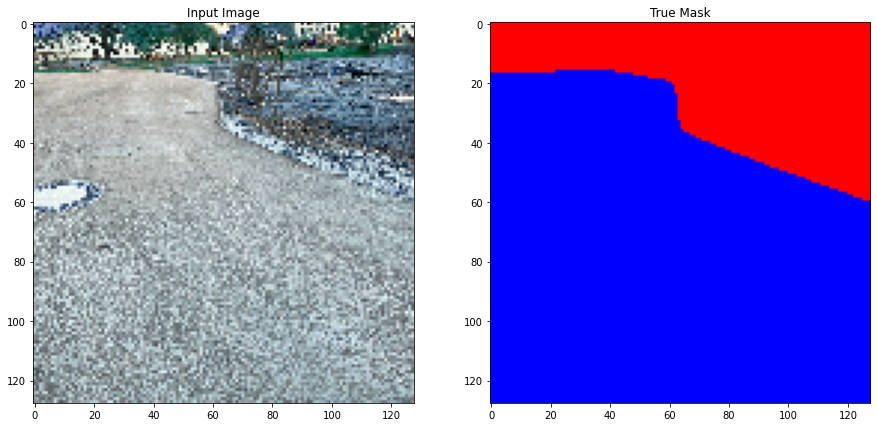

Index: 3


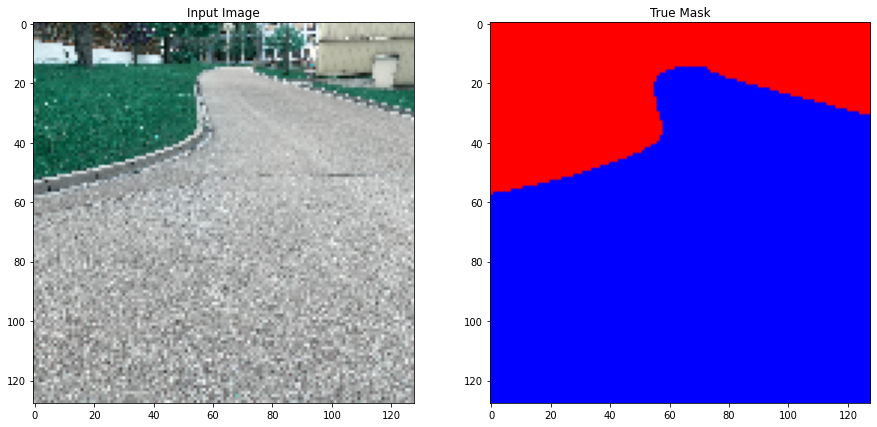

Index: 4


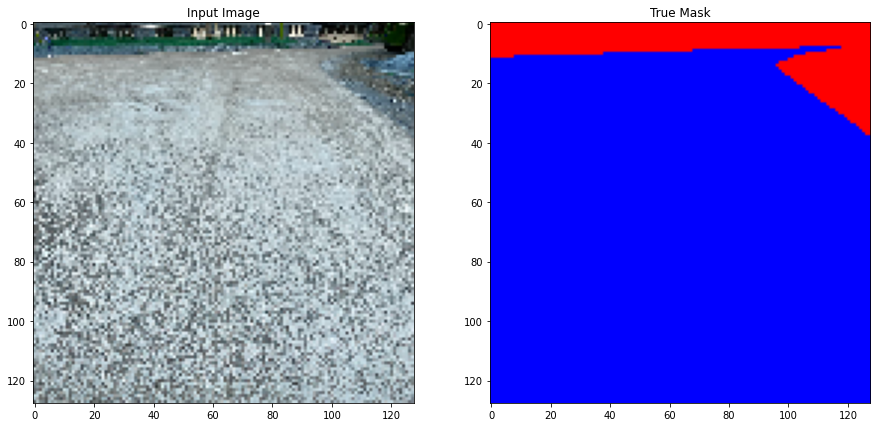

Index: 5


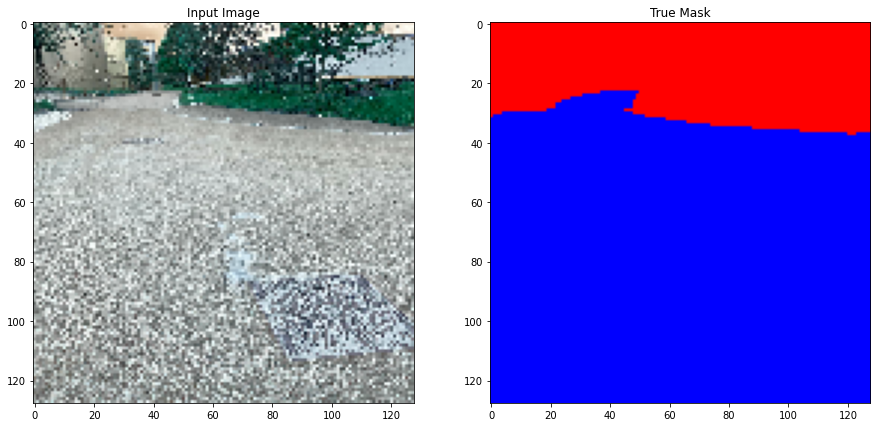

Index: 6


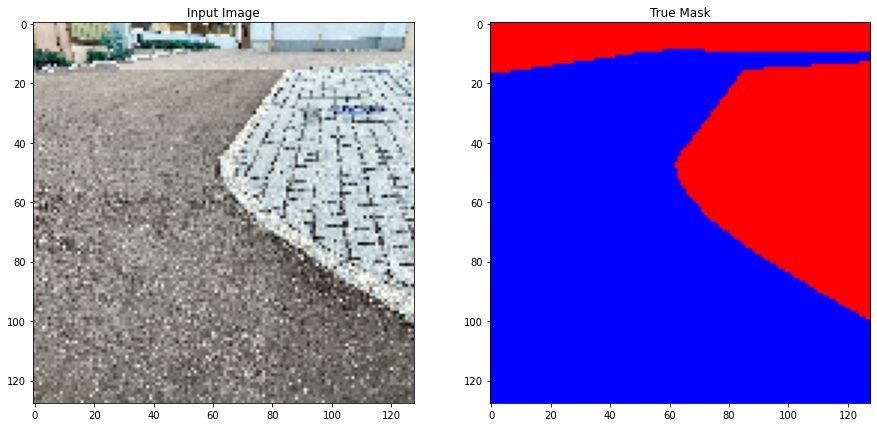

Index: 7


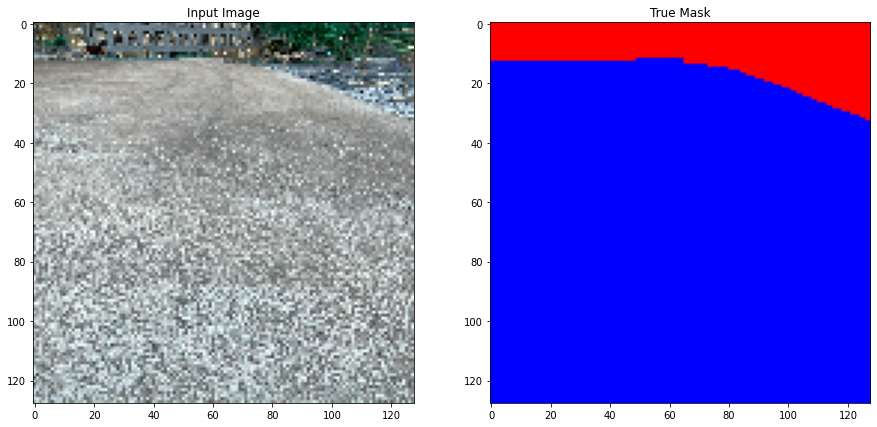

Index: 8


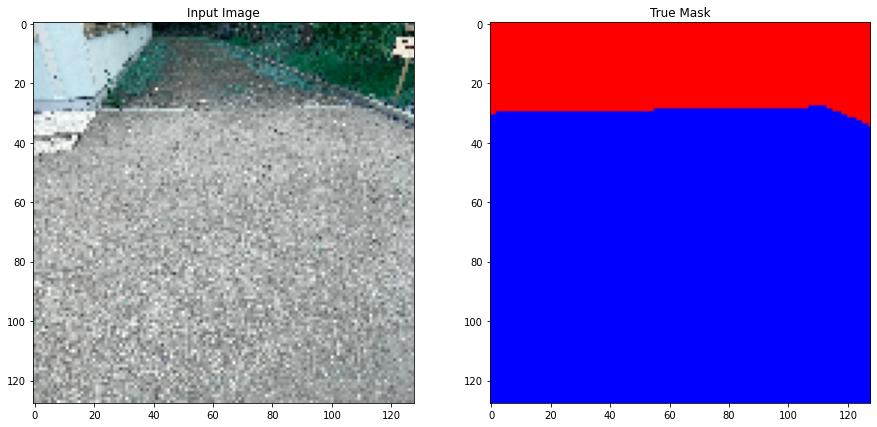

Index: 9


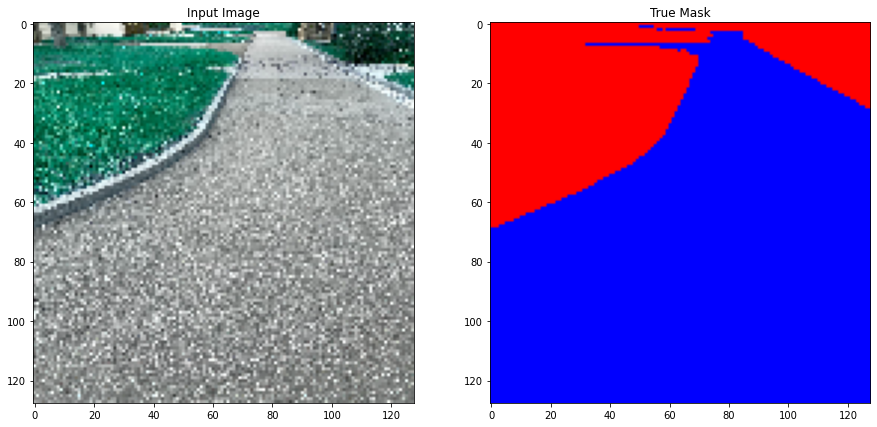

In [17]:
#print(plt.imshow(test_data[0][0]))

myimages = []
mymasks = []
for x in test_data: 
    myimages.append(x[0])
    mymasks.append(x[1])

manualDisplay(myimages, mymasks) 

In [18]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128, 3], include_top=False)

#Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

#create the feature extaction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [19]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [20]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [21]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
#tf.keras.utils.plot_model(model, show_shapes=True)

In [23]:
def create_mask(pred_mask): 
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [24]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                create_mask(model.predict(sample_image[tf.newaxis, ...]))])


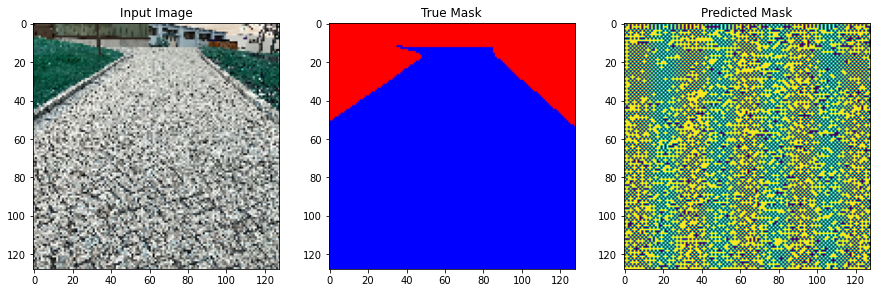

In [25]:
show_predictions()

In [27]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [44]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(test_data)
STEPS_PER_EPOCH = len(training_data)

nurImages = []
nurMasks = []

for x in training_data: 
    nurImages.append(x[0])
    nurMasks.append(x[1])

nurImagesTest = []
nurMaskTest = []

for x in test_data: 
    nurImagesTest.append(x[0])
    nurMaskTest.append(x[1])


model_history = model.fit(training_data, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_data,
                          callbacks=[DisplayCallback()])


Epoch 1/20


ValueError: in user code:

    F:\Python3\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    F:\Python3\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    F:\Python3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    F:\Python3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    F:\Python3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    F:\Python3\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    F:\Python3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 train_step
        y_pred = self(x, training=True)
    F:\Python3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    F:\Python3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:200 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model_1 expects 1 input(s), but it received 96 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:4' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:5' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:6' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:7' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:8' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:9' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:10' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:11' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:12' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:13' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:14' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:15' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:16' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:17' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:18' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:19' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:20' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:21' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:22' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:23' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:24' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:25' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:26' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:27' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:28' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:29' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:30' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:31' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:32' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:33' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:34' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:35' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:36' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:37' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:38' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:39' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:40' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:41' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:42' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:43' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:44' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:45' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:46' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:47' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:48' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:49' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:50' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:51' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:52' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:53' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:54' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:55' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:56' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:57' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:58' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:59' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:60' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:61' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:62' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:63' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:64' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:65' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:66' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:67' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:68' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:69' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:70' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:71' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:72' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:73' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:74' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:75' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:76' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:77' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:78' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:79' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:80' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:81' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:82' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:83' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:84' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:85' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:86' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:87' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:88' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:89' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:90' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:91' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:92' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:93' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:94' shape=(2, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:95' shape=(2, 128, 3) dtype=uint8>]


In [40]:
print(len(test_data))
print(len(training_data))
print(np.shape(training_data))
#training_data[0][0] - image
#training_data[0][1] - mask



10
96
(96, 2, 128, 128, 3)
